In [1]:
#Importing Necessary Libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#Data Loading using keras utility
data_dir = r"D:\DBDA PRJ S"

img_height = 224
img_width = 224
batch_size = 64

#using 70% of the images for training and 30% for validation

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2118 files belonging to 6 classes.
Using 1483 files for training.
Found 2118 files belonging to 6 classes.
Using 635 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

class_names = val_ds.class_names
print(class_names)

['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'NORMAL', 'Uveitis']
['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'NORMAL', 'Uveitis']


In [4]:
#for checking file formats as desired
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'D:\DBDA PRJ S'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
        os.remove(bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Bulging_Eyes
processing class directory  Cataracts
processing class directory  Crossed_Eyes
processing class directory  Glaucoma
processing class directory  NORMAL
processing class directory  Uveitis
 no improper image files were found


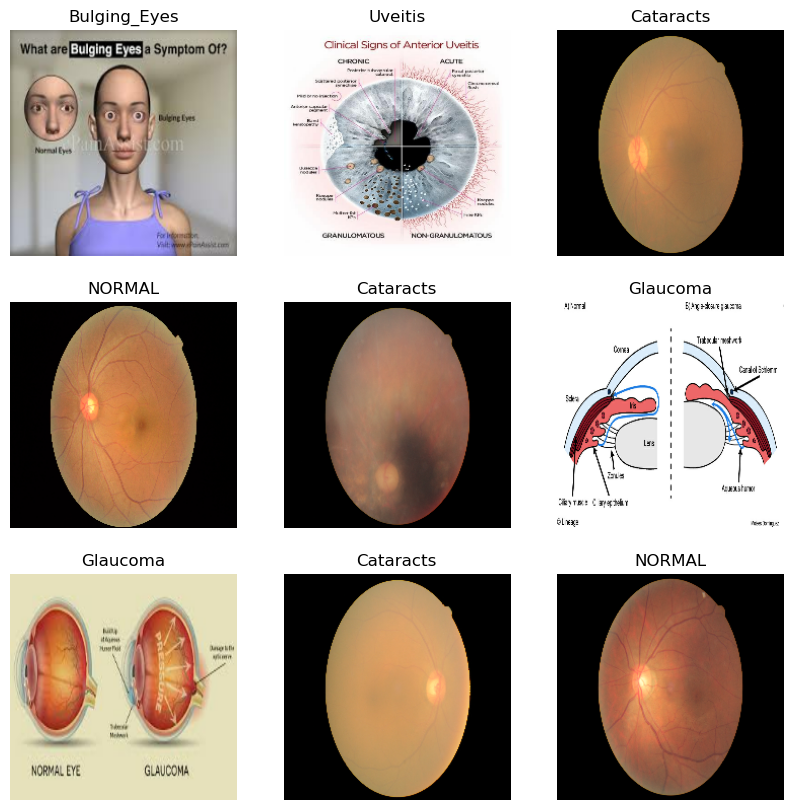

In [5]:
#Visualizing Data loaded

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
#Data Shape Verifying as per input given
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [7]:
#Data Set configuration for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
#Standardizing the data for furthur processing
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.040214933 1.0


In [10]:
#Model Building
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
#Model Compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [14]:
#Model Training
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
24/24 [==============================] - 89s 4s/step - loss: 1.5350 - accuracy: 0.3331 - val_loss: 1.3262 - val_accuracy: 0.4567
Epoch 2/100
24/24 [==============================] - 59s 2s/step - loss: 1.2480 - accuracy: 0.4498 - val_loss: 1.1648 - val_accuracy: 0.5134
Epoch 3/100
24/24 [==============================] - 60s 3s/step - loss: 1.1130 - accuracy: 0.5246 - val_loss: 1.1437 - val_accuracy: 0.5024
Epoch 4/100
24/24 [==============================] - 60s 3s/step - loss: 0.9904 - accuracy: 0.5968 - val_loss: 1.0660 - val_accuracy: 0.5748
Epoch 5/100
24/24 [==============================] - 61s 3s/step - loss: 0.8761 - accuracy: 0.6392 - val_loss: 1.0835 - val_accuracy: 0.5780
Epoch 6/100
24/24 [==============================] - 61s 3s/step - loss: 0.7869 - accuracy: 0.6811 - val_loss: 1.0466 - val_accuracy: 0.5669
Epoch 7/100
24/24 [==============================] - 61s 3s/step - loss: 0.6936 - accuracy: 0.7235 - val_loss: 1.1553 - val_accuracy: 0.5669
Epoch 8/100
2

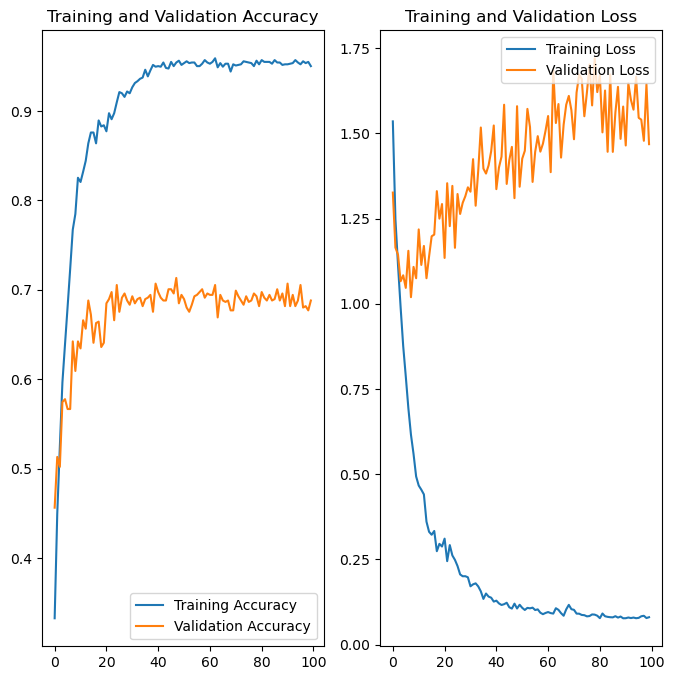

In [15]:
#Visualizing Results of Trained Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
#Data Augmantation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

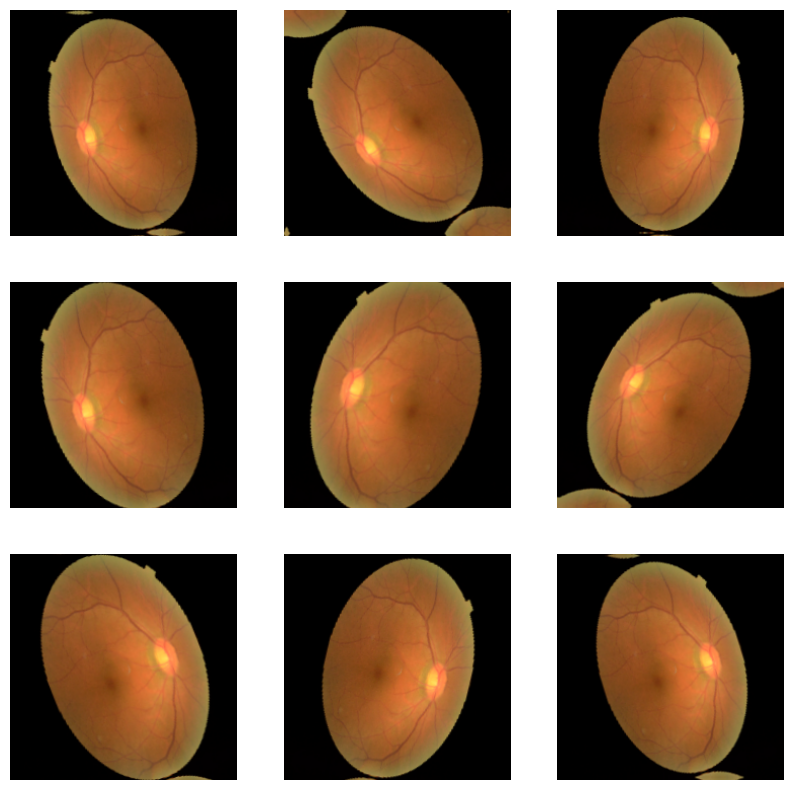

In [17]:
#Data Augmantation - Visualization
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
#Dropout - for avoiding overfitting
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
#Model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [21]:
#Model Training
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
24/24 [==============================] - 93s 4s/step - loss: 1.5945 - accuracy: 0.3061 - val_loss: 1.3771 - val_accuracy: 0.3228
Epoch 2/100
24/24 [==============================] - 75s 3s/step - loss: 1.3243 - accuracy: 0.3803 - val_loss: 1.2794 - val_accuracy: 0.4110
Epoch 3/100
24/24 [==============================] - 81s 3s/step - loss: 1.2757 - accuracy: 0.4228 - val_loss: 1.2407 - val_accuracy: 0.4331
Epoch 4/100
24/24 [==============================] - 78s 3s/step - loss: 1.2005 - accuracy: 0.4855 - val_loss: 1.2551 - val_accuracy: 0.4409
Epoch 5/100
24/24 [==============================] - 74s 3s/step - loss: 1.1547 - accuracy: 0.5172 - val_loss: 1.1690 - val_accuracy: 0.4724
Epoch 6/100
24/24 [==============================] - 85s 4s/step - loss: 1.1198 - accuracy: 0.5347 - val_loss: 1.2016 - val_accuracy: 0.4756
Epoch 7/100
24/24 [==============================] - 78s 3s/step - loss: 1.0859 - accuracy: 0.5367 - val_loss: 1.0651 - val_accuracy: 0.5890
Epoch 8/100
2

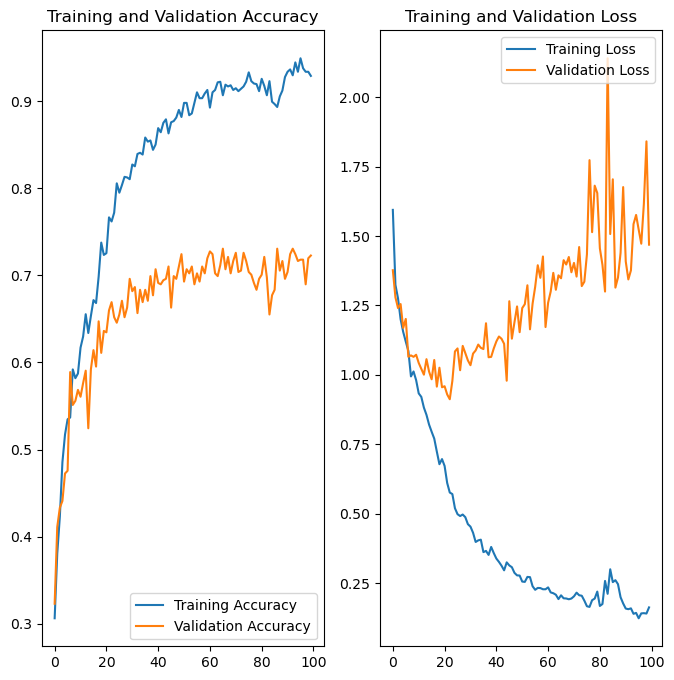

In [22]:
#Visualizing the results - after augmantation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()